# Spiral - 2.0
Попытка сделать сеть, аналогичную

http://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=8,8,8,8&seed=0.69219&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

но средствами tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

epoch_for_train=800 #Сколько эпох обучать
samples_per_epoch=250 #сколько семплов прогонять за одну эпоху - в playground.tensorflow.org это 250 точек (и 250 на тест)
train_batch_size = 10 #Размер батча
summary_every_epoch = 20 #каждые сколько эпох печатать ошибку
#в оригинале на сайте оно как-то работает с конфигурацией 4 слоя по 8 (т.е.) [8, 8, 8, 8, 1]
layers_sizes = [50, 50, 50, 50, 1] #сколько нейронов в каждом слое (да и число слоёв)

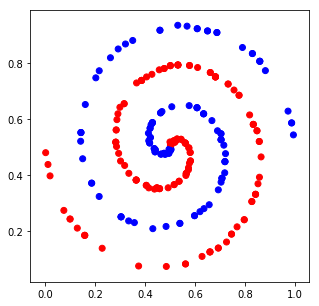

In [2]:
#функция генерации данных - чему обучаем сеть
def generate_data(num_of_data):
    xs = np.zeros((num_of_data, 2))
    ys = np.zeros((num_of_data, 1))
    noise=0.01
    size=1

    for i in range(int(num_of_data)):
        if (i%2):    #положительные
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 1
        else: #отрицательные
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2 +math.pi;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 0  
    return xs, ys

#генерируем данные
data_x, data_y=generate_data(samples_per_epoch)

#функция для отдачи данных tensorflow по батчам. Берет случайные точки из сгенерированных data_x, data_y
dict_index=0
def feed_my_dict(x,y_,batch_size):
    global dict_index
    xs = np.zeros((batch_size, 2))
    ys = np.zeros((batch_size, 1))
    for i in range(batch_size):
        dict_index=int(round(random.random()*(len(data_x[:,0])-1)))
        xs[i][0] = data_x[dict_index,0]
        xs[i][1] = data_x[dict_index,1]
        ys[i][0] = data_y[dict_index,0]
    return {x: xs, y_: ys}


#нарисуем данные
fig, ax = plt.subplots(figsize=(5,5))

#Будем гонять одну эпоху
for j in range(int(samples_per_epoch/train_batch_size)):#одну эпоху
    my_x="x"
    my_y="y"
    #пользуемся той же функцией для рисования, что и кормит нейросеть (для верификации)
    feed_dict=feed_my_dict(my_x,my_y,train_batch_size)
    colors = []
    for i in range(len(feed_dict[my_x][:,0])):#делаем массив цветов из выхода y
        colors.append((int(feed_dict[my_y][i,0]),0,int(1-feed_dict[my_y][i,0])))
    ax.scatter(feed_dict[my_x][:,0], feed_dict[my_x][:,1], color=colors)
plt.show()

In [3]:
print("Creating network with sizes:")
print(layers_sizes)

sess = tf.Session()
# Create a multilayer model.

# Input placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 2], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, 1], name='y-input')

# We can't initialize these variables to 0 - the network will get stuck.
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.

    It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])

        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])

        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases

        activations = act(preactivate, name='activation')
        return activations

#С помощью функции создания слоя nn_layer делаем слоев как указано в массиве layers_sizes
layers=[]
for n in range(len(layers_sizes)):
    if n == 0:#Входной слой
        activations=nn_layer(x, 2, layers_sizes[0], "layer" + str(n))
        layers.append(activations)
    else: #все остальные слои одинаково
        activations = nn_layer(layers[n-1], layers_sizes[n - 1], layers_sizes[n], "layer" + str(n))
        layers.append(activations)

y = layers[len(layers_sizes) - 1] #Выход сети - последний слой

loss=tf.reduce_mean(tf.square(y_-y))
train_step = tf.train. AdamOptimizer(0.0005).minimize(loss)


sess.run(tf.global_variables_initializer())

#обучение
for i in range(epoch_for_train):#по эпохам
    if ((i % summary_every_epoch) == 0):#печатаем ошибку
        loss_my = sess.run(loss, feed_dict=feed_my_dict(x,y_,samples_per_epoch))
        print('Loss at epoch %s: %s' % (i, loss_my))
    for j in range(int(samples_per_epoch/train_batch_size)):#один расчет train_step прогоняет 1 батч
        sess.run(train_step, feed_dict=feed_my_dict(x,y_,train_batch_size))


Creating network with sizes:
[50, 50, 50, 50, 1]
Loss at epoch 0: 0.317927
Loss at epoch 20: 0.24106
Loss at epoch 40: 0.225127
Loss at epoch 60: 0.234644
Loss at epoch 80: 0.223097
Loss at epoch 100: 0.202581
Loss at epoch 120: 0.182574
Loss at epoch 140: 0.149091
Loss at epoch 160: 0.0879217
Loss at epoch 180: 0.0641942
Loss at epoch 200: 0.0871496
Loss at epoch 220: 0.0636994
Loss at epoch 240: 0.042696
Loss at epoch 260: 0.0242265
Loss at epoch 280: 0.0305545
Loss at epoch 300: 0.0253619
Loss at epoch 320: 0.0145579
Loss at epoch 340: 0.0162231
Loss at epoch 360: 0.0073902
Loss at epoch 380: 0.0076229
Loss at epoch 400: 0.00610276
Loss at epoch 420: 0.0088431
Loss at epoch 440: 0.00563073
Loss at epoch 460: 0.00680729
Loss at epoch 480: 0.00529607
Loss at epoch 500: 0.00578096
Loss at epoch 520: 0.00507999
Loss at epoch 540: 0.00709398
Loss at epoch 560: 0.00183412
Loss at epoch 580: 0.00294158
Loss at epoch 600: 0.00326982
Loss at epoch 620: 0.00302069
Loss at epoch 640: 0.0039967

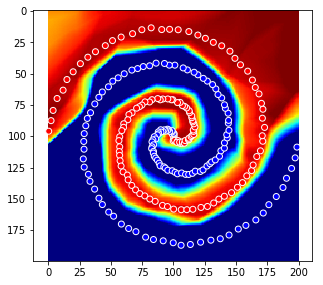

In [4]:
#теперь попробуем нарисовать картинку, чему обучилась сеть, как в оригинале.
#для этого прогоним через сеть все сочетания входов (сетку иксов от 0 до 1 с небольшим шагом)
#Получив выходы сети, нарисуем это в цвете, чем больше выход, тем теплее цвет.

#данные на вход сети для этой затеи - просто матрица размером dimension
def feed_dict_for_plot(x,y_,dimension):   
    xs = np.zeros((dimension*dimension, 2))
    ys = np.zeros((dimension*dimension, 1))
    index = 0
    for i in range(dimension):
        for j in range(dimension):
            xs[index][0] = i / dimension
            xs[index][1] = j / dimension
            ys[index][0] = 0 #мы не обучаем, поэтому все равно что тут
            index += 1
    return {x: xs, y_: ys}

#такого разрешения будем рисовать картинку
image_size=200
#просим tensorflow вернуть нам выход сети после прогона нашей сетки иксов
#Будет массив формой (image_size^2, 1)
output_activation = sess.run(y, feed_dict=feed_dict_for_plot(x,y_,image_size))
output_activation = output_activation[:,0] #избавимся от лишней размерности 1

#функция создания rgb массива из массива выходов сети
def plot_output(my_y,dimension):
    out_picture = np.zeros([dimension, dimension, 3])#пустой rgb массив
    #приводим все значения массива в диапазон 0-1
    my_y_normed = (my_y - my_y.min(0)) / my_y.ptp(0)

    for i in range(dimension):
        for j in range(dimension):
            rgba=cm.jet(my_y[i*dimension+j])#делаем из выхода в диапазоне 0-1 цвет с палитрой jet
            out_picture[j, i, :] = rgba[0:3]#кладем цвет в выходной массив картинки
    return out_picture

#нарисуем, чему научилась сеть
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(plot_output(output_activation,image_size))


#и поверх дорисуем еще исходные данные
colors = []
for i in range(len(data_x[:,0])):#делаем массив цветов
    colors.append((int(data_y[i,0]),0,int(1-data_y[i,0])))
ax.scatter(data_x[:,0]*image_size, data_x[:,1]*image_size, color=colors, edgecolors ='w')
plt.show()

В чем проблема? В оригинале для обучения спирали хватает сети 4 слоя по 8, и порядка 300 эпох, причем с оптимизатором gradient descent "обычный". Здесь же стоит адам и сеть  [50, 50, 50, 50, 1] для получения аналогичного по точности результата. Если сделать [8, 8, 8, 8, 1] то получается полная порнография.
# ЧЯДНТ?